## Imports iniciais

In [ ]:
# https://www.kaggle.com/c/titanic
import pandas as pd

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import KFold

# Algoritmos de aprendizados
from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

# Análise exploratória

In [ ]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data.head() # Conhecendo na prática as colunas

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.shape

(891, 12)

In [ ]:
# Testando agrupamentos por classe e sexo
data[['Age', 'Survived', 'Fare', 'Pclass', 'Sex']].groupby(['Pclass', 'Sex']).mean()

# Temos agora a noção de qual grupo teve uma taxa maior de sobrevivência. A idade média será útil para a imputação

Age  Survived        Fare
Pclass Sex                                    
1      female  34.611765  0.968085  106.125798
       male    41.281386  0.368852   67.226127
2      female  28.722973  0.921053   21.970121
       male    30.740707  0.157407   19.741782
3      female  21.750000  0.500000   16.118810
       male    26.507589  0.135447   12.661633

In [ ]:
# O número de ticket tem uma notação diferente, vamos investigar
data['Ticket'].unique()[:4]
# Com os 5 primeiros, vemos que a notação é estranha. Pode ter alguma informação importante nisso
# Com certa análise, os prefixos possuem relação com a acomodação e a numeração ajuda a reconhecer parentes(números próximos)
# Porém por conta da natureza qualitativa, essa coluna não será usada

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803'],
      dtype=object)

In [ ]:
# Verificando nulos nas colunas
for coluna in data:
  print(coluna, data[coluna].isna().sum())

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


## Arrumando valores faltantes / errôneos

In [ ]:
# Mais de 75% dos elementos de Cabin são nulos, não compensa manter a coluna pois a imputação seria inconsistente
data = data.drop(columns='Cabin')

# ========================================
test_data = test_data.drop(columns='Cabin') # OBS: todas as alterações serão replicadas nos dados da submissão

In [ ]:
# A coluna de ticket não será usada por ser muito variada(a ponto da numeração quase servir como identificação por ser única)
data = data.drop(columns='Ticket')
test_data = test_data.drop(columns='Ticket')

In [ ]:
# Embarked possui apenas dois valores nulos, vamos completá-los usando a moda
moda = data.loc[data['Embarked'].notnull(), 'Embarked'].mode()
print('Moda da coluna Embarked:', moda[0])
print(data['Embarked'].unique())
data['Embarked'] = data['Embarked'].fillna(moda[0])
print('Elementos únicos após imputação:')
print(data['Embarked'].unique())

Moda da coluna Embarked: S
['S' 'C' 'Q' nan]
Elementos únicos após imputação:
['S' 'C' 'Q']


In [ ]:
# Idade possui 177 valores nulos (20%). Pode valer a pena ainda fazer imputação
# Vamos preencher cada valor faltante com a média de seu agrupamento(mesma classe, mesmo sexo)

data['Age'] = data['Age'].fillna(data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'))

In [ ]:
# Não há mais elementos nulos no dataframe
for coluna in data:
  print(coluna, data[coluna].isna().sum())

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Fare 0
Embarked 0


## Testando novas features

In [ ]:
# Verifica se há relação entre pronome de tratamento e classe social

# Retorna o pronome de tratamento da pessoa ou erro se não possuir
def obtemPronome(linha):
  nomeSplitado = linha['Name'].split()
  for palavra in nomeSplitado:
    if(palavra[-1] == '.'):
      return palavra

  return 'ERRO'


data['Pronome'] = data.apply(obtemPronome, axis=1)
test_data['Pronome'] = test_data.apply(obtemPronome, axis=1)
print(data['Pronome'].unique())

# Já podemos apagar a coluna de nomes, pois o foco nela são os pronomes
data = data.drop(columns='Name')
test_data = test_data.drop(columns='Name')

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.']


In [ ]:
# Convertendo a coluna sexo de string para numerico
data['Sex'] = np.where(data['Sex'] == 'female', 1, 0)
test_data['Sex'] = np.where(test_data['Sex'] == 'female', 1, 0)

In [ ]:
data[['Pronome', 'Age', 'Fare', 'Survived', 'Pclass', 'Sex']].groupby(['Pclass', 'Pronome']).mean()

Age        Fare  Survived  Sex
Pclass Pronome                                        
1      Capt.      70.000000   71.000000  0.000000  0.0
       Col.       58.000000   31.025000  0.500000  0.0
       Countess.  33.000000   86.500000  1.000000  1.0
       Don.       40.000000   27.720800  0.000000  0.0
       Dr.        43.256277   63.935840  0.600000  0.2
       Jonkheer.  38.000000    0.000000  0.000000  0.0
       Lady.      48.000000   39.600000  1.000000  1.0
       Major.     48.500000   28.525000  0.500000  0.0
       Master.     5.306667  117.802767  1.000000  0.0
       Miss.      30.100256  124.402715  0.956522  1.0
       Mlle.      24.000000   59.402100  1.000000  1.0
       Mme.       24.000000   69.300000  1.000000  1.0
       Mr.        41.524558   68.034385  0.345794  0.0
       Mrs.       39.687955   93.170636  0.976190  1.0
       Sir.       49.000000   56.929200  1.000000  0.0
2      Dr.        38.500000   12.250000  0.000000  0.0
       Master.     2.258889   27.306022  1.000000  0.0
       Miss.      22.763116   20.393750  0.941176  1.0
       Mr.        32.567762   19.252564  0.087912  0.0
       Mrs.       33.682927   23.496139  0.902439  1.0
       Ms.        28.000000   13.000000  1.000000  1.0
       Rev.       43.166667   18.312500  0.000000  0.0
3      Master.     8.373227   28.177232  0.392857  0.0
       Miss.      17.943627   15.248043  0.500000  1.0
       Mr.        28.099320   11.299762  0.112853  0.0
       Mrs.       30.994048   18.233529  0.500000  1.0

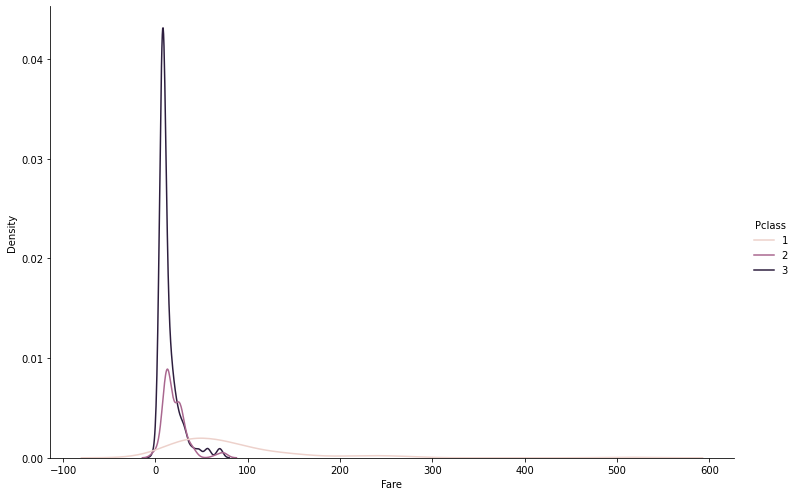

In [ ]:
# Relação entre classe de viagem e custo do ingresso
sns.displot(data=data, x="Fare", hue="Pclass", kind="kde", height=7, aspect=1.5)

plt.show()
# Percebemos que existem outliers, pois o gráfico está alcançando taxas altas

## Remoção de outliers

In [ ]:
# Apagando os outliers(taxas extremas)
Q1 = data['Fare'].quantile(0.25)
Q3 = data['Fare'].quantile(0.75)
IQR = Q3 - Q1

# Encontra os outliers
print('Entrada média com outliers:', data['Fare'].mean())
tamanho_antigo = len(data)
data = data[(data['Fare'] <= Q3 + (IQR*4)) & (data['Fare'] >= Q1 - (IQR*4))] 
print('Quantidade de outliers removidos:', tamanho_antigo - len(data))
print('Entrada média sem outliers:', data['Fare'].mean())

Entrada média com outliers: 32.2042079685746
Quantidade de outliers removidos: 38
Entrada média sem outliers: 24.0037702227432


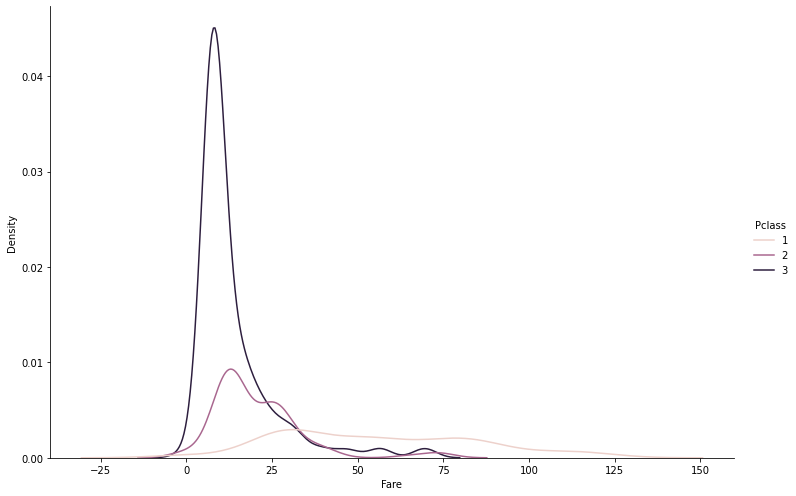

In [ ]:
sns.displot(data=data, x="Fare", hue="Pclass", kind="kde", height=7, aspect=1.5)

plt.show()
# OBS: a remoção de outliers ocorreu após a imputação de dados pois ela não afeta muito a distribuição de idades

## Convertendo todos os dados em quantitativos

In [ ]:
# Pclass é numérico, mas ele representa uma hierarquia. Precisamos passá-lo para o get dummies
data['Pclass'] = data['Pclass'].apply(str)
test_data['Pclass'] = test_data['Pclass'].apply(str)

In [ ]:
test_data.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Pronome'],
      dtype='object')

In [ ]:
# A coluna pronome acabou se mostrando inconsistente no get dummies, pois os dados base não necessariamente possuem todos os pronomes dos
# dados da submissão, fazendo com que o número de colunas seja diferente
# Dessa forma, a coluna de pronome será desconsiderada
data = data.drop(columns='Pronome')
test_data = test_data.drop(columns='Pronome')

# Aplica o get dummies nas demais colunas categóricas
data = pd.get_dummies(data, prefix=['Pclass', 'Embarked'])
test_data = pd.get_dummies(test_data, prefix=['Pclass', 'Embarked'])

In [ ]:
# Disposição dos dados atualmente:
data.shape

(853, 13)

In [ ]:
data.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,22.0,1,0,7.2500,0,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,3,1,1,26.0,0,0,7.9250,0,0,1,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,0,1
4,5,0,0,35.0,0,0,8.0500,0,0,1,0,0,1


# Aplicando o aprendizado de máquina

Tamanho treino: (682, 11)
Tamanho teste: (171, 11)
Acuracia: 0.8304093567251462
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


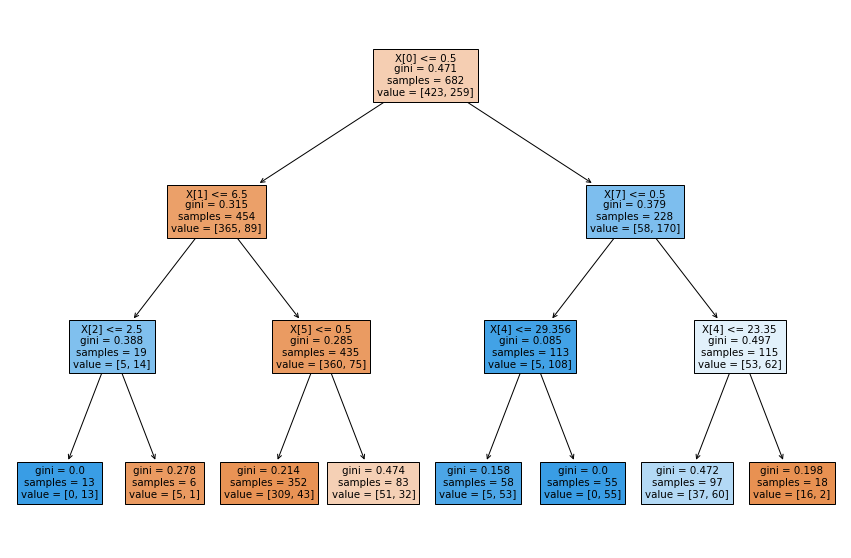

In [ ]:
# Separando dados de treino e de teste
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)

# Aplicando uma árvore de decisão inicial para entender a lógica mais simples de classificação
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test))
print('Acuracia:', acc)

print(X_train.columns)

plt.figure(figsize=(15,10))
tree.plot_tree(clf, filled=True) 
plt.show(True)

In [ ]:
# Aplicação massiva de algoritmos para ver os que mais se destacam

# Normalizando os dados para o knn e SVM
y = data['Survived']
min_max_scaler = preprocessing.MinMaxScaler()
escalado = min_max_scaler.fit_transform(data.drop(columns=['Survived', 'PassengerId']).values)

X_norm = pd.DataFrame(escalado)
X = data.drop(columns=['Survived', 'PassengerId'])

# Definição inicial da validação cruzada
numeroFolds = 5
kf = KFold(n_splits=numeroFolds, shuffle=True)

# Calcula as scores dos algoritmos
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, X_norm, y, cv=kf)
print('Acurácia com 1 K-NN: %0.4f' % (scores.mean()))

knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X_norm, y, cv=kf)
print('Acurácia com 3 K-NN: %0.4f' % (scores.mean()))

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_norm, y, cv=kf)
print('Acurácia com 5 K-NN: %0.4f' % (scores.mean()))

knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X_norm, y, cv=kf)
print('Acurácia com 7 K-NN: %0.4f' % (scores.mean()))

clf = tree.DecisionTreeClassifier(max_depth=3)
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia para árvore com profundidade 3: %0.4f' % (scores.mean()))

clf = tree.DecisionTreeClassifier(max_depth=4)
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia para árvore com profundidade 4: %0.4f' % (scores.mean()))

clf = tree.DecisionTreeClassifier(max_depth=5)
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia para árvore com profundidade 5: %0.4f' % (scores.mean()))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia Random Forest: %0.4f' % (scores.mean()))

clf = XGBClassifier() # O XGBoost aparentou ser ligeiramente melhor
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia XGBoost: %0.4f' % (scores.mean()))

clf = SVC()
scores = cross_val_score(clf, X_norm, y, cv=kf)
print('Acurácia SVC: %0.4f' % (scores.mean()))

clf = GaussianNB()
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia Naive Bayes: %0.4f' % (scores.mean()))

clf = AdaBoostClassifier()
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia AdaBoost: %0.4f' % (scores.mean()))

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X, y, cv=kf)
print('Acurácia RegLog até 1000 iter: %0.4f' % (scores.mean()))

Acurácia com 1 K-NN: 0.7503
Acurácia com 3 K-NN: 0.8008
Acurácia com 5 K-NN: 0.8078
Acurácia com 7 K-NN: 0.8078
Acurácia para árvore com profundidade 3: 0.8136
Acurácia para árvore com profundidade 4: 0.8077
Acurácia para árvore com profundidade 5: 0.8112
Acurácia Random Forest: 0.8125
Acurácia XGBoost: 0.8160
Acurácia SVC: 0.8100
Acurácia Naive Bayes: 0.7620
Acurácia AdaBoost: 0.8101
Acurácia RegLog até 1000 iter: 0.8043


## Ajustes finais no dataframe da submissão

In [ ]:
# Tratamento de nulos em teste
for coluna in test_data:
  print(coluna, test_data[coluna].isna().sum())

PassengerId 0
Sex 0
Age 86
SibSp 0
Parch 0
Fare 1
Pclass_1 0
Pclass_2 0
Pclass_3 0
Embarked_C 0
Embarked_Q 0
Embarked_S 0


In [ ]:
# 86 elementos nulos na coluna Age
media = test_data.loc[test_data['Age'].notnull(), 'Age'].mean()
print('Media da coluna Age:', media)
test_data['Age'] = test_data['Age'].fillna(media)

# 1 elemento nulo na coluna Fare
media = test_data.loc[test_data['Fare'].notnull(), 'Fare'].mean()
print('Media da coluna Fare:', media)
test_data['Fare'] = test_data['Fare'].fillna(media)

Media da coluna Age: 30.272590361445783
Media da coluna Fare: 35.6271884892086


In [ ]:
# Tratamento de nulos em teste
for coluna in test_data:
  print(coluna, test_data[coluna].isna().sum())

PassengerId 0
Sex 0
Age 0
SibSp 0
Parch 0
Fare 0
Pclass_1 0
Pclass_2 0
Pclass_3 0
Embarked_C 0
Embarked_Q 0
Embarked_S 0


In [ ]:
print(test_data.shape)
test_data.head()

(418, 12)


,PassengerId,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,0,34.5,0,0,7.8292,0,0,1,0,1,0
1,893,1,47.0,1,0,7.0000,0,0,1,0,0,1
2,894,0,62.0,0,0,9.6875,0,1,0,0,1,0
3,895,0,27.0,0,0,8.6625,0,0,1,0,0,1
4,896,1,22.0,1,1,12.2875,0,0,1,0,0,1


## Aplicando o aprendizado nos dados de submissão

In [ ]:
# >>>>>>>>>> Dados de treino

y_train = data['Survived']
X_train = data.drop(columns=['Survived', 'PassengerId'])

#min_max_scaler = preprocessing.MinMaxScaler()
#escalado = min_max_scaler.fit_transform(data.drop(columns=['Survived', 'PassengerId']).values)
#X_norm_train = pd.DataFrame(escalado)

# >>>>>>>>>> Dados de teste

X_test = test_data.drop(columns=['PassengerId'])

#min_max_scaler = preprocessing.MinMaxScaler()
#escalado = min_max_scaler.fit_transform(test_data.drop(columns=['PassengerId']).values)
#X_norm_test = pd.DataFrame(escalado)

# >>>>>>>>>> Aplicando o algoritmo
clf = XGBClassifier() # Usaremos o XGBoost pois ele foi ligeiramente melhor
clf = clf.fit(X_train, y_train)
survived = pd.DataFrame(clf.predict(X_test))

submission = pd.concat([test_data['PassengerId'], survived], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission = submission.set_index('PassengerId')
submission.to_csv('submission.csv')